In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import keras.utils.to_categorical
#import keras_utils
from keras.datasets import cifar10
from megaman.geometry import Geometry

Using TensorFlow backend.


In [2]:
(X_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [4]:
label_dict = {
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
}

Text(0.5,1,'Label: horse')
Text(0.5,1,'Label: automobile')
Text(0.5,1,'Label: horse')
Text(0.5,1,'Label: deer')
Text(0.5,1,'Label: automobile')
Text(0.5,1,'Label: deer')


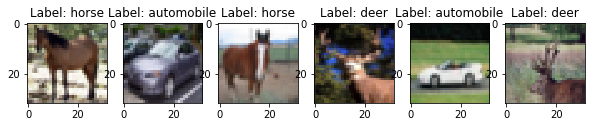

In [5]:
plt.figure(figsize=[10,5])
#subplot(nrows, ncols, index, **kwargs)
# Display the first image in training data
for i in range(6):
    plt.subplot(1,6,i+1)
    curr_img = np.reshape(X_train[i], (32,32,3))
    plt.imshow(curr_img)
    print(plt.title("Label: " + str(label_dict[y_train[i][0]])))



In [6]:
X_train = X_train.reshape((50000,-1))

In [7]:
"""
Preprocess data?
Normalize:
dataset=dataset/255.

Zero-centering:
mean = dataset.mean(axis=(0,1,2))
#keepdims=True
dataset[..., 0] -= mean[0]
dataset[..., 1] -= mean[1]
dataset[..., 2] -= mean[2]

Set std to 1:
std = dataset.std(axis=(0,1,2))
dataset[..., 0] /= std[0]
dataset[..., 1] /= std[1]
dataset[..., 2] /= std[2]
"""


'\nPreprocess data?\nNormalize:\ndataset=dataset/255.\n\nZero-centering:\nmean = dataset.mean(axis=(0,1,2))\n#keepdims=True\ndataset[..., 0] -= mean[0]\ndataset[..., 1] -= mean[1]\ndataset[..., 2] -= mean[2]\n\nSet std to 1:\nstd = dataset.std(axis=(0,1,2))\ndataset[..., 0] /= std[0]\ndataset[..., 1] /= std[1]\ndataset[..., 2] /= std[2]\n'

In [8]:
batchsize = 4092
X_train_batch = X_train[:batchsize, :]
y_train_batch = y_train[:batchsize]

In [9]:
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
X_train_batch = preprocessing.normalize(X_train_batch)
#X_train_batch = scaler.fit_transform(X_train_batch) #does not work for ltsa

In [10]:
X_train_batch.std()

0.0079122670340531793

In [11]:
#y_train_batch = np.squeeze(y_train_batch).shape
y_train_batch = y_train_batch.reshape((batchsize,))

In [ ]:
# simple example from manifold_intro
from megaman.embedding import LTSA
from megaman.geometry import Geometry

geom = Geometry(adjacency_kwds=dict(n_neighbors=64))
model = LTSA(geom=geom, eigen_solver='dense', random_state=64)

X_ltsa = model.fit_transform(X_train_batch)
print(X_ltsa.shape)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_ltsa[:, 1], X_ltsa[:, 0], s=20, lw=0.1)

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [12]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(18, 12))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 11})

    plt.xticks([]), plt.yticks([])
    plt.figtext(.5,.9, str(title), fontsize=30, ha='center')
    #if title is not None:
     #   plt.title(title)
        
    plt.savefig(str(title) + '.png' , format = 'png')     

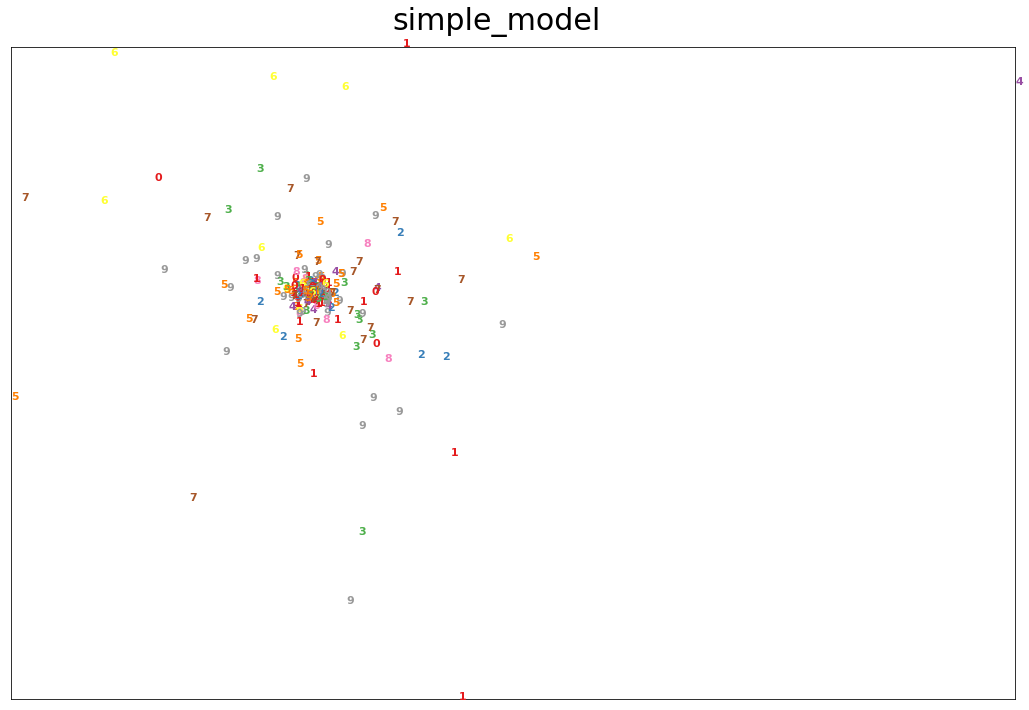

In [34]:
plot_embedding(X_ltsa, y_train_batch, 'simple_model')

In [13]:
# Initialize Radius
geom = Geometry()
geom.set_data_matrix(X_train_batch)

In [15]:
# Radius Selection
from scipy.sparse.csgraph import connected_components
rad1 = 0.7272
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

4


In [16]:
radius = rad1
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'symmetricnormalized'
laplacian_kwds = {'scaling_epps':radius}

geom  = {'adjacency_method':adjacency_method, 'adjacency_kwds':adjacency_kwds,
         'affinity_method':affinity_method, 'affinity_kwds':affinity_kwds,
         'laplacian_method':laplacian_method, 'laplacian_kwds':laplacian_kwds}

In [17]:
geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X_train_batch)

In [18]:
from megaman.embedding import (Isomap, LocallyLinearEmbedding,
                               LTSA, SpectralEmbedding)

In [19]:
n_components = 2

In [20]:
spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
embed_spectral = spectral.fit_transform(X_train_batch)

ltsa = LTSA(n_components=n_components,eigen_solver='dense',geom=geom)
embed_ltsa = ltsa.fit_transform(X_train_batch)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='dense',geom=geom)
embed_lle = lle.fit_transform(X_train_batch)

isomap = Isomap(n_components=n_components, eigen_solver='dense',geom=geom)
embed_isomap = isomap.fit_transform(X_train_batch)

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/megaman/embedding/spectral_embedding.py:202: UserWarning: Graph is not fully connected: spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected: "
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-package

ValueError: failed to create intent(cache|hide)|optional array-- must have defined dimensions but got (0,)

In [ ]:
embed_spectral = embed_spectral[:, [0, 2]] * 50.0
tmp = embed_spectral[:, 1].copy()
embed_spectral[:,1] = embed_spectral[:,0].copy()
embed_spectral[:,0] = tmp.copy()
tmp = None

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=y_train_batch)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=y_train_batch)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=y_train_batch)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=y_train_batch)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

In [ ]:
plot_embedding(embed_ltsa, y_train_batch, 'Megaman LTSA Embedding')

In [ ]:
plot_embedding(embed_lle, y_train_batch, 'Megaman LLE Embedding')

In [ ]:
plot_embedding(embed_isomap, y_train_batch, 'Megaman Isomap Embedding')

In [ ]:
plot_embedding(embed_spectral, y_train_batch, 'Megaman Spectral Embedding')

In [ ]:
# Accuracy of embedding
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21)
# Train the model using the training sets
knn.fit(embed_spectral, y_train_batch)

In [ ]:
#Predict Output
predicted = knn.predict(embed_spectral) 

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_train_batch, predicted))

In [11]:
# Radius Estimation

rmax=3
rmin=0.1

geom = Geometry(adjacency_method='brute',adjacency_kwds=dict(radius=rmax))
geom.set_data_matrix(X_train_batch)
dist = geom.compute_adjacency_matrix()

In [12]:
X_train_batch.shape

(48, 3072)

In [13]:
from megaman.utils.estimate_radius import run_estimate_radius

# subsample by 10.
sample = np.arange(0,X_train_batch.shape[0],10)

distorion_vs_rad_dim1 = run_estimate_radius(
    X_train_batch, dist, sample=sample, d=1, rmin=rmin, rmax=rmax,
    ntry=25, run_parallel=True, search_space='logspace')

using 4 processes to perform asynchronous parallel radius search
performing parallel radius search...

for radius: 0.1 distortion is: inf
for radius: 0.1 analysis took: 0.017059803009033203 seconds

for radius: 0.152981937474 distortion is: inf
for radius: 0.152981937474 analysis took: 0.025052785873413086 seconds

for radius: 0.11522500057 distortion is: inf
for radius: 0.11522500057 analysis took: 0.030519485473632812 seconds

for radius: 0.132768007565 distortion is: inf
for radius: 0.132768007565 analysis took: 0.037079811096191406 seconds

for radius: 0.176273438327 distortion is: inf
for radius: 0.176273438327 analysis took: 0.02897047996520996 seconds

for radius: 0.203111070318 distortion is: inf
for radius: 0.203111070318 analysis took: 0.02456378936767578 seconds

for radius: 0.234034731932 distortion is: inf
for radius: 0.234034731932 analysis took: 0.02281498908996582 seconds

for radius: 0.269666521204 distortion is: inf
for radius: 0.269666521204 analysis took: 0.01979184

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


for radius: 0.310723250595 distortion is: 0.995406631974
for radius: 0.310723250595 analysis took: 40.99096322059631 seconds

for radius: 0.358030867271 distortion is: 0.959742519706
for radius: 0.358030867271 analysis took: 41.63730192184448 seconds

for radius: 0.412541068855 distortion is: 0.938181424165
for radius: 0.412541068855 analysis took: 115.79337525367737 seconds

for radius: 0.475350448942 distortion is: 0.859832603481
for radius: 0.475350448942 analysis took: 155.8286418914795 seconds

for radius: 0.547722557505 distortion is: 0.733531469835
for radius: 0.547722557505 analysis took: 194.70912170410156 seconds

for radius: 0.63111332001 distortion is: 0.554809990476
for radius: 0.63111332001 analysis took: 194.37170934677124 seconds

for radius: 0.727200326582 distortion is: 0.323346384215
for radius: 0.727200326582 analysis took: 194.41009879112244 seconds

for radius: 0.837916580452 distortion is: 0.402236374932
for radius: 0.837916580452 analysis took: 189.4885387420654

In [14]:
distorion_vs_rad_dim2 = run_estimate_radius(
    X_train_batch, dist, sample=sample, d=2, rmin=rmin, rmax=rmax,
    ntry=25, run_parallel=True, search_space='logspace')

using 4 processes to perform asynchronous parallel radius search
performing parallel radius search...

for radius: 0.1 distortion is: inf
for radius: 0.1 analysis took: 0.012131452560424805 seconds

for radius: 0.176273438327 distortion is: inf
for radius: 0.176273438327 analysis took: 0.011593818664550781 seconds

for radius: 0.11522500057 distortion is: inffor radius: 0.132768007565 distortion is: inf
for radius: 0.11522500057 analysis took: 0.028041362762451172 seconds


for radius: 0.132768007565 analysis took: 0.028446197509765625 seconds

for radius: 0.152981937474 distortion is: inf
for radius: 0.152981937474 analysis took: 0.03551030158996582 seconds

for radius: 0.203111070318 distortion is: inf
for radius: 0.203111070318 analysis took: 0.020201683044433594 seconds

for radius: 0.234034731932 distortion is: inf
for radius: 0.269666521204 distortion is: inf
for radius: 0.234034731932 analysis took: 0.021747589111328125 seconds
for radius: 0.269666521204 analysis took: 0.0238435

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


for radius: 0.310723250595 distortion is: 0.998620890337
for radius: 0.310723250595 analysis took: 35.27944040298462 seconds

for radius: 0.358030867271 distortion is: 0.991073213359
for radius: 0.358030867271 analysis took: 38.10231304168701 seconds

for radius: 0.412541068855 distortion is: 0.988336976348
for radius: 0.412541068855 analysis took: 110.02806520462036 seconds

for radius: 0.475350448942 distortion is: 0.977441751939
for radius: 0.475350448942 analysis took: 143.80570363998413 seconds

for radius: 0.547722557505 distortion is: 0.95719618741
for radius: 0.547722557505 analysis took: 183.51773524284363 seconds

for radius: 0.63111332001 distortion is: 0.895020208513
for radius: 0.63111332001 analysis took: 181.1021068096161 seconds

for radius: 0.727200326582 distortion is: 0.799122715974
for radius: 0.727200326582 analysis took: 179.305082321167 seconds

for radius: 0.837916580452 distortion is: 0.706282914029
for radius: 0.837916580452 analysis took: 184.2006962299347 se

In [15]:
distorsion_dim1 = distorion_vs_rad_dim1[:,1].astype('float64')
distorsion_dim2 = distorion_vs_rad_dim2[:,1].astype('float64')
rad_search_space = distorion_vs_rad_dim1[:,0].astype('float64')

argmin_d1 = np.argmin(distorsion_dim1)
argmin_d2 = np.argmin(distorsion_dim2)
est_rad_dim1 = rad_search_space[argmin_d1]
est_rad_dim2 = rad_search_space[argmin_d2]

print ('Estimated radius with d=2 is: {:.4f}'.format(est_rad_dim1))
print ('Estimated radius with d=1 is: {:.4f}'.format(est_rad_dim2))

Estimated radius with d=2 is: 0.7272
Estimated radius with d=1 is: 1.2819


In [16]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

from IPython.core.display import display, HTML
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [17]:
from megaman.plotter.scatter_3d import scatter_plot3d_plotly
import plotly.graph_objs as go
from plotly.offline import iplot


t_distorsion = [go.Scatter(x=rad_search_space, y=distorsion_dim1, name='Dimension = 1'), 
                go.Scatter(x=rad_search_space, y=distorsion_dim2, name='Dimension = 2')]

l_distorsion = go.Layout(
    title='Distorsions versus radii',
    xaxis=dict(
        title='$\\text{Radius } r$',
        type='log',
        autorange=True
    ),
    yaxis=dict(
        title='Distorsion',
        type='log',
        autorange=True
    ),
    annotations=[
        dict(
            x=np.log10(est_rad_dim1),
            y=np.log10(distorsion_dim1[argmin_d1]),
            xref='x',
            yref='y',
            text='$\\hat{r}_{d=1}$',
            font = dict(size = 30),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-30
        ),
        dict(
            x=np.log10(est_rad_dim2),
            y=np.log10(distorsion_dim2[argmin_d2]),
            xref='x',
            yref='y',
            text='$\\hat{r}_{d=2}$',
            font = dict(size = 30),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-30
        )
    ]
)
f_distorsion = go.Figure(data=t_distorsion,layout=l_distorsion)
iplot(f_distorsion)